In [2]:
from __future__ import division

import urllib
import os
import glob
import random
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPool2D, Dropout
from keras.utils import to_categorical
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

import utils
from scipy import ndimage 

Using TensorFlow backend.


In [3]:
image_size = (512,512)
n_slices = 32
ratio = (1, 1)
gray = False

## Load Training Images

In [4]:
CORPUS_PATH = "data/train/"
TEST_PATH = "data/test/"
OUTPUT_PATH = "output"

In [5]:
classes = os.listdir(CORPUS_PATH)

image_list = []
label_list = []

for label, c in enumerate(classes):
    print(c)
    terrain_path = os.path.join(CORPUS_PATH, c)
    for f_name in os.listdir(terrain_path):
        img = cv2.imread(os.path.join(terrain_path, f_name))
        if gray:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
        img_resize = cv2.resize(img, image_size)
        slices = utils.prepare_images(img_resize, image_size, ratio, n_slices)
        if gray:
            slices = np.expand_dims(slices, -1)
        image_list.append(slices)
        label_list.append(np.full((slices.shape[0]), label))
        
X_train = np.concatenate(image_list)
labels = np.concatenate(label_list)
one_hot_labels = to_categorical(labels, num_classes=len(classes))

vegetation
water
desert
clouds


In [6]:
X_train.shape

(197632, 16, 16, 3)

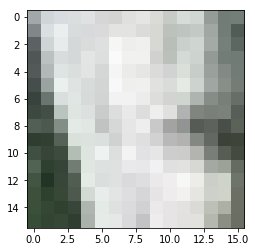

In [7]:
plt.imshow(X_train[15, :, :])

## Create Model

In [8]:
if gray:
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
else:
    input_shape = (X_train.shape[1], X_train.shape[2], 3)

In [9]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape, activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

opt = optimizers.rmsprop(lr=0.001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

## Train Model

In [10]:
history = model.fit(X_train, one_hot_labels, epochs=32, batch_size=2056)

Epoch 1/32
197632/197632 [==============================] - 13s - loss: 5.0658 - acc: 0.5217    
Epoch 2/32
197632/197632 [==============================] - 11s - loss: 0.7158 - acc: 0.7221    
Epoch 3/32
197632/197632 [==============================] - 11s - loss: 0.6209 - acc: 0.7827    
Epoch 4/32
197632/197632 [==============================] - 11s - loss: 0.4872 - acc: 0.8177    
Epoch 5/32
197632/197632 [==============================] - 11s - loss: 0.4725 - acc: 0.8284    
Epoch 6/32
197632/197632 [==============================] - 11s - loss: 0.4777 - acc: 0.8251    
Epoch 7/32
197632/197632 [==============================] - 11s - loss: 0.4239 - acc: 0.8443    
Epoch 8/32
197632/197632 [==============================] - 11s - loss: 0.4119 - acc: 0.8485    
Epoch 9/32
197632/197632 [==============================] - 11s - loss: 0.3979 - acc: 0.8570    
Epoch 10/32
197632/197632 [==============================] - 11s - loss: 0.3679 - acc: 0.8680    
Epoch 11/32
197632/197632 [==

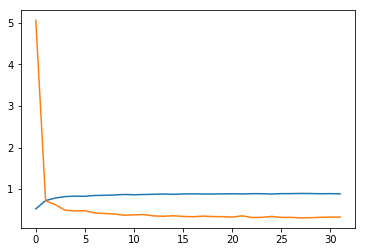

In [11]:
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])

## Read test images

In [147]:
def download_image(url, file_name):
    return urllib.urlretrieve(url, file_name)

In [148]:
with open("test_images.txt", 'r') as f:
    image_urls = f.read().split("\n")

In [149]:
for i, image_url in enumerate(image_urls):
    download_image(image_url, os.path.join(TEST_PATH, str(i)))

In [12]:
image_list = []
gray_list = []
for f_name in os.listdir(TEST_PATH):
    img = cv2.imread(os.path.join(TEST_PATH, f_name))    
    if gray:
        img = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)

    img_resize = cv2.resize(img, image_size)
    slices = utils.prepare_images(img_resize, image_size, ratio, n_slices)
    gray_list.append(np.expand_dims(slices, -1))
    image_list.append(img_resize)
    
images = np.stack(image_list)
X = np.stack(gray_list)
X = X.reshape(X.shape[0] * X.shape[1], X.shape[2], X.shape[3], X.shape[4])

In [13]:
X.shape

(57344, 16, 16, 3)

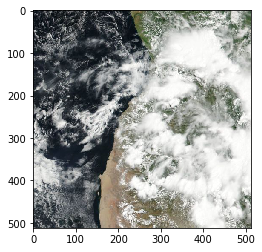

In [14]:
plt.imshow(images[48])

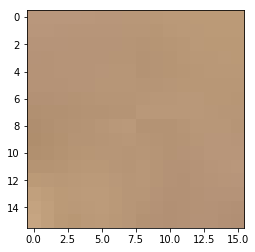

In [15]:
plt.imshow(X[0,:, :])

## Predict Labels

vegetation

water

desert

clouds

In [16]:
preds = model.predict(X)

In [17]:
labels = np.argmax(preds, axis=1)

In [18]:
labels = np.reshape(labels, (len(images), n_slices, n_slices))

## Visualize Predictions

In [19]:
colors = [(124,252,0), (0,191,255), (244,164,96), (255, 255, 255)]

In [20]:
for i, (img, l) in enumerate(zip(images, labels)):
    assignment_mask = np.zeros((l.shape[0], l.shape[1], 3))
    
    for label in xrange(len(classes)):
        assignment_mask[np.isin(l, label)] = colors[label]
        
    alpha = 0.5
    output = img.copy()
    output = output.astype('uint8')
    assignment_mask = assignment_mask.astype('uint8')
    assignment_mask = cv2.resize(assignment_mask, image_size, interpolation=cv2.INTER_CUBIC)
    assignment_mask = cv2.flip(ndimage.rotate(assignment_mask, 90),0)
    overlay = assignment_mask
    output = cv2.addWeighted(overlay, alpha, output, 1 - alpha,
                    0, output)
    cv2.imwrite(os.path.join(OUTPUT_PATH, "{}.jpg".format(i)), img)
    cv2.imwrite(os.path.join(OUTPUT_PATH, "{}_overlay.jpg".format(i)), output)
    cv2.imwrite(os.path.join(OUTPUT_PATH, "{}_labels.jpg".format(i)), assignment_mask)

In [21]:
classes

['vegetation', 'water', 'desert', 'clouds']

In [22]:
np.bincount(l.flatten()) / l.size

array([ 0.09863281,  0.02832031,  0.08984375,  0.78320312])